In [12]:
import numpy as np
import random
import matplotlib.pyplot as plt

from scipy.special import logsumexp
from scipy.stats import pearsonr
from sklearn.linear_model import Ridge
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error

import torch
import torch.distributions as D

import isosplit

from clusterless import preprocess
from clusterless import decoder

In [2]:
seed = 666
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.set_default_dtype(torch.double)

In [3]:
SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 25

plt.rc('font', size=MEDIUM_SIZE)         
plt.rc('axes', titlesize=MEDIUM_SIZE)     
plt.rc('axes', labelsize=MEDIUM_SIZE) 
plt.rc('axes', linewidth = 1.5)
plt.rc('xtick', labelsize=MEDIUM_SIZE)   
plt.rc('ytick', labelsize=MEDIUM_SIZE)   
plt.rc('legend', fontsize=MEDIUM_SIZE)   
plt.rc('figure', titlesize=MEDIUM_SIZE)

#### load data

In [4]:
pid = 'febb430e-2d50-4f83-87a0-b5ffbb9a4943'
rootpath = '/mnt/3TB/yizi/Downloads/ONE/openalyx.internationalbrainlab.org'
trial_data_path = rootpath + '/danlab/Subjects/DY_009/2020-02-27/001/alf'
neural_data_path = '/mnt/3TB/yizi/danlab/Subjects/DY_009'
behavior_data_path = rootpath + '/paper_repro_ephys_data/figure9_10/original_data'
save_path = '../saved_results/danlab/Subjects/DY_009'

In [6]:
roi = 'po'

In [8]:
sorted_trials, good_sorted_trials, unsorted_trials, stim_on_times, np1_channel_map= preprocess.load_neural_data(
    pid=pid, 
    trial_data_path=trial_data_path,
    neural_data_path=neural_data_path,
    behavior_data_path=behavior_data_path,
    keep_active_trials=True, 
    # roi='all',
    roi = roi,
    kilosort=True,
    triage=False,
    good_units=True,
    thresholding=True
)

behave_dict = preprocess.load_behaviors_data(behavior_data_path, pid)
motion_energy, wheel_velocity, wheel_speed, paw_speed, nose_speed, pupil_diameter = preprocess.preprocess_dynamic_behaviors(behave_dict)

pid: febb430e-2d50-4f83-87a0-b5ffbb9a4943
eid: db4df448-e449-4a6f-a0e7-288711e7a75a
found 85 good ibl units ..
1st trial stim on time: 40.81, last trial stim on time 2252.10
found 88 neurons in region po ...
found 64 channels in region po ...


In [9]:
class DataLoader():
    def __init__(self, data, y, stim_on_times, np1_channel_map, n_t_bins=30):
        self.data = data
        self.y = y
        self.stim_on_times = stim_on_times
        self.np1_channel_map = np1_channel_map
        self.n_t_bins = n_t_bins
        self.n_trials = stim_on_times.shape[0]
        self.n_channels = np1_channel_map.shape[0]
        self.t_binning = np.arange(0, 1.5, step = (1.5 - 0) / n_t_bins)
        self.rand_trial_ids = np.arange(self.n_trials)
        
        # allocate unsorted data into trials
        self.trial_ids = []
        self.t_ids = []
        self.trials = []
        self.t_bins = []
        for k in range(self.n_trials):
            mask = np.logical_and(data[:,0] >= stim_on_times[k] - 0.5,
                                  data[:,0] <= stim_on_times[k] + 1)
            trial = data[mask,:]
            trial[:,0] = trial[:,0] - trial[:,0].min()
            t_bins = np.digitize(trial[:,0], self.t_binning, right = False) - 1
            t_bin_lst = []
            for t in range(self.n_t_bins):
                t_bin = trial[t_bins == t,1:]
                self.trial_ids.append(np.ones_like(t_bin[:,0]) * k)
                self.t_ids.append(np.ones_like(t_bin[:,0]) * t)
                t_bin_lst.append(t_bin)
            self.trials.append(t_bin_lst)
    
    
    def split_train_test(self, train_ids, test_ids):
        
        self.train_ids = self.rand_trial_ids[train_ids]
        self.test_ids = self.rand_trial_ids[test_ids]
        self.y_train = self.y[self.train_ids]
        self.y_test = self.y[self.test_ids]
        
        trial_ids = np.concatenate(self.trial_ids)
        t_ids = np.concatenate(self.t_ids)
        trials = np.concatenate(np.concatenate(self.trials))

        train_mask = np.sum([trial_ids == idx for idx in self.train_ids], axis=0).astype(bool)
        test_mask = np.sum([trial_ids == idx for idx in self.test_ids], axis=0).astype(bool)
        train_trial_ids, test_trial_ids = trial_ids[train_mask], trial_ids[test_mask]
        train_t_ids, test_t_ids = t_ids[train_mask], t_ids[test_mask]
        train_trials, test_trials = trials[train_mask], trials[test_mask]
        
        return train_trials, train_trial_ids, train_t_ids, \
               test_trials, test_trial_ids, test_t_ids

In [10]:
data_loader = DataLoader(data = np.concatenate(unsorted_trials)[:,[0,1,2,3,4]], 
                         y = wheel_velocity, 
                         stim_on_times = stim_on_times, 
                         np1_channel_map = np1_channel_map, 
                         n_t_bins=30)

In [13]:
kf = KFold(n_splits=5, shuffle=True, random_state=seed)
# kf = KFold(n_splits=5, shuffle=False)
kf_train_ids = []; kf_test_ids = []
for i, (train_ids, test_ids) in enumerate(kf.split(data_loader.y)):
    kf_train_ids.append(train_ids)
    kf_test_ids.append(test_ids)

In [14]:
i = 0
train_trials, train_trial_ids, train_t_ids, \
test_trials, test_trial_ids, test_t_ids = data_loader.split_train_test(
    train_ids = kf_train_ids[i], test_ids = kf_test_ids[i]
)

<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [15]:
train_trials.shape

(67503, 4)

In [16]:
sub_weights_lst = []
sub_means_lst = []
sub_covs_lst = []

all_trials = np.vstack([train_trials, test_trials])
for channel in np.unique(all_trials[:,0]):
    sub_s = all_trials[all_trials[:,0] == channel, 1:]
    
    if sub_s.shape[0] > 10:
        try:
            isosplit_labels = isosplit.isosplit(sub_s.T, K_init=20, min_cluster_size=10,
                                                whiten_cluster_pairs=1, refine_clusters=1)
        except AssertionError:
            continue
        except ValueError:
            continue
    elif sub_s.shape[0] < 2:
        continue
    else:
        sub_gmm = GaussianMixture(n_components=1, 
                              covariance_type='full',
                              init_params='k-means++', 
                              verbose=0)
        sub_gmm.fit(sub_s)
        sub_labels = sub_gmm.predict(sub_s)
        sub_weights = len(sub_labels)/len(all_trials)
        sub_weights_lst.append(sub_weights)
        sub_means_lst.append(sub_gmm.means_)
        sub_covs_lst.append(sub_gmm.covariances_)
        continue
    
    n_splits = np.unique(isosplit_labels).shape[0]
    print(f'channel {channel} has {n_splits} modes ...')
    
    if n_splits == 1: 
        sub_gmm = GaussianMixture(n_components=1, 
                              covariance_type='full',
                              init_params='k-means++', 
                              verbose=0)
        sub_gmm.fit(sub_s)
        sub_labels = sub_gmm.predict(sub_s)
        sub_weights = len(sub_labels)/len(all_trials)
        sub_weights_lst.append(sub_weights)
        sub_means_lst.append(sub_gmm.means_)
        sub_covs_lst.append(sub_gmm.covariances_)
    else:
        for label in np.arange(n_splits):
            mask = isosplit_labels == label
            sub_gmm = GaussianMixture(n_components=1, 
                              covariance_type='full',
                              init_params='k-means++', 
                              verbose=0)
            sub_gmm.fit(sub_s[mask])
            sub_labels = sub_gmm.predict(sub_s[mask])
            sub_weights = len(sub_labels)/len(all_trials)
            sub_weights_lst.append(sub_weights)
            sub_means_lst.append(sub_gmm.means_)
            sub_covs_lst.append(sub_gmm.covariances_)
            
sub_weights = np.hstack(sub_weights_lst)
sub_means = np.vstack(sub_means_lst)
sub_covs = np.vstack(sub_covs_lst)

channel 93.0 has 1 modes ...
channel 97.0 has 1 modes ...
channel 101.0 has 1 modes ...
channel 102.0 has 2 modes ...
channel 105.0 has 1 modes ...
channel 106.0 has 1 modes ...
channel 110.0 has 1 modes ...
channel 114.0 has 1 modes ...
channel 116.0 has 1 modes ...
channel 118.0 has 1 modes ...
channel 119.0 has 1 modes ...
channel 120.0 has 1 modes ...
channel 121.0 has 1 modes ...
channel 122.0 has 1 modes ...
channel 124.0 has 3 modes ...
channel 125.0 has 1 modes ...
channel 126.0 has 1 modes ...
channel 131.0 has 1 modes ...
channel 132.0 has 2 modes ...
channel 133.0 has 1 modes ...
channel 134.0 has 2 modes ...
channel 136.0 has 3 modes ...
channel 137.0 has 1 modes ...
channel 138.0 has 2 modes ...
channel 140.0 has 3 modes ...
channel 141.0 has 3 modes ...
channel 142.0 has 3 modes ...
channel 144.0 has 2 modes ...
channel 145.0 has 2 modes ...
channel 146.0 has 1 modes ...
channel 244.0 has 1 modes ...
channel 245.0 has 2 modes ...
channel 246.0 has 1 modes ...
channel 247.

In [17]:
gmm = GaussianMixture(n_components=len(sub_weights), covariance_type='full', init_params='k-means++')
gmm.weights_ = sub_weights
gmm.means_ = sub_means
gmm.covariances_ = sub_covs
gmm.precisions_cholesky_ = np.linalg.cholesky(np.linalg.inv(sub_covs))

In [43]:
s = torch.tensor(train_trials[:,1:])
y = torch.tensor(data_loader.y)
ks = torch.tensor(train_trial_ids)
ts = torch.tensor(train_t_ids)

Nk = len(data_loader.train_ids)
Nt = data_loader.n_t_bins
Nc = gmm.means_.shape[0]
Nd = gmm.means_.shape[1]
print(Nc)

57


#### CAVI-SGD

In [22]:
def safe_log(x, minval=1e-10):
    return torch.log(x + minval)

In [34]:
class ADVI(torch.nn.Module):

    def __init__(self, Nk, Nt, Nc, Nd, init_means, init_covs):
        super(ADVI, self).__init__()
        self.Nk = Nk
        self.Nt = Nt
        self.Nc = Nc
        self.Nd = Nd
        
        # initialize variables for variational distribution
        self.means = torch.nn.Parameter(torch.tensor(init_means), requires_grad=False)
        self.covs = torch.nn.Parameter(torch.tensor(init_covs), requires_grad=False)
        self.b_mu = torch.nn.Parameter(torch.randn((Nc)))
        self.b_log_sig = torch.nn.Parameter(torch.randn((Nc)))
        self.beta_mu = torch.nn.Parameter(torch.randn((Nc, Nt)))
        self.beta_log_sig = torch.nn.Parameter(torch.randn((Nc, Nt)))
        
    def log_prior_plus_logabsdet_J(self, b_sample, beta_sample):
        
        # log prior for beta, evaluated at sampled values for beta
        lp_b = D.Normal(torch.zeros((Nc)), torch.ones((Nc))).log_prob(b_sample).sum()

        # log prior sig + log jacobian
        lp_beta = D.Normal(torch.zeros((Nc, Nt)), torch.ones((Nc, Nt))).log_prob(beta_sample).sum()

        return lp_b + lp_beta
    
    
    def log_q(self, b_sample, beta_sample):
        
        lq_b = self.b.log_prob(b_sample).sum()

        lq_beta = self.beta.log_prob(beta_sample).sum()

        return lq_b + lq_beta
        
        
    def forward(self, s, y, ks, ts, sampling=True):
        
        # define variational distributions
        self.b = D.Normal(self.b_mu, self.b_log_sig.exp())
        self.beta = D.Normal(self.beta_mu, self.beta_log_sig.exp())
        
        # sample from the variational distributions
        if sampling:
            b_sample = self.b.rsample()
            beta_sample = self.beta.rsample()
        else:
            b_sample = self.b.loc
            beta_sample = self.beta.loc
                    
        # mixing proportions 
        log_lambdas = torch.zeros((self.Nk, self.Nc, self.Nt))
        for k in range(self.Nk):
            for t in range(self.Nt):
                log_lambdas[k,:,t] = b_sample + beta_sample[:,t] * y[k][t]
        log_pis = log_lambdas - torch.logsumexp(log_lambdas, 1)[:,None,:]
                                          
                                          
        # sample from the variational distributions
        pi_sample = torch.zeros((s.shape[0], self.Nc))
        for k in range(self.Nk):
            for t in range(self.Nt):
                k_t_idx = torch.logical_and(ks == torch.unique(ks).int()[k], ts == t)
                pi_sample[k_t_idx] = torch.exp(log_pis)[k,:,t]
                                          
                            
        # mixture density
        density = D.mixture_same_family.MixtureSameFamily(
            mixture_distribution=D.categorical.Categorical(probs=pi_sample),
            component_distribution=
                D.multivariate_normal.MultivariateNormal(
                                           loc=self.means,
                                           covariance_matrix=self.covs)
                )
                               
                                          
        # compute the mean log likelihood
        elbo = density.log_prob(s).mean() * N
        elbo += self.log_prior_plus_logabsdet_J(b_sample, beta_sample)
        elbo -= self.log_q(b_sample, beta_sample)                                  
        
        return elbo

In [44]:
batch_size = 1
batch_ids = list(zip(*(iter(data_loader.train_ids),) * batch_size))

In [45]:
advi = ADVI(batch_size, Nt, Nc, Nd, gmm.means_, gmm.covariances_)
optim = torch.optim.Adam(advi.parameters(), lr=1e-2)

In [46]:
%%time
max_iter = 50
elbos = []
N = s.shape[0]
for i in range(max_iter):
    tot_elbo = 0
    for n, batch_idx in enumerate(batch_ids): 
        mask = torch.logical_and(ks >= batch_idx[0], ks <= batch_idx[-1])
        batch_s = s[mask]
        batch_y = y[list(batch_idx)]
        batch_ks = ks[mask]
        batch_ts = ts[mask]
        loss = - advi(batch_s, batch_y, batch_ks, batch_ts) / N
        loss.backward()
        tot_elbo -= loss.item()
        if (n+1) % 100 == 0:
            print(f'iter: {i+1} batch {n+1}')
        optim.step()
        optim.zero_grad()
    print(f'iter: {i+1} total elbo: {tot_elbo:.2f}')
    elbos.append(tot_elbo)

iter: 1 batch 100
iter: 1 total elbo: -3069.05
iter: 2 batch 100
iter: 2 total elbo: -2669.14
iter: 3 batch 100
iter: 3 total elbo: -2489.46
iter: 4 batch 100
iter: 4 total elbo: -2406.25
iter: 5 batch 100
iter: 5 total elbo: -2346.55
iter: 6 batch 100
iter: 6 total elbo: -2304.95
iter: 7 batch 100
iter: 7 total elbo: -2283.63
iter: 8 batch 100
iter: 8 total elbo: -2263.33
iter: 9 batch 100
iter: 9 total elbo: -2249.25
iter: 10 batch 100
iter: 10 total elbo: -2236.44
iter: 11 batch 100
iter: 11 total elbo: -2229.37
iter: 12 batch 100
iter: 12 total elbo: -2222.68
iter: 13 batch 100
iter: 13 total elbo: -2214.57
iter: 14 batch 100
iter: 14 total elbo: -2211.21
iter: 15 batch 100
iter: 15 total elbo: -2207.81
iter: 16 batch 100
iter: 16 total elbo: -2205.48
iter: 17 batch 100
iter: 17 total elbo: -2202.76
iter: 18 batch 100
iter: 18 total elbo: -2199.99
iter: 19 batch 100
iter: 19 total elbo: -2199.11
iter: 20 batch 100
iter: 20 total elbo: -2197.03
iter: 21 batch 100
iter: 21 total elbo

In [48]:
elbos = [elbo for elbo in elbos]

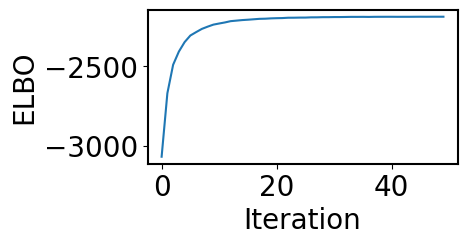

In [49]:
plt.figure(figsize=(4,2))
plt.plot(elbos)
plt.xlabel("Iteration")
plt.ylabel("ELBO");

In [50]:
log_lambdas = torch.zeros((Nk, Nc, Nt))
for k in range(Nk):
    for t in range(Nt):
        log_lambdas[k,:,t] = advi.b.loc + advi.beta.loc[:,t] * y[k][t]

log_pis = log_lambdas - torch.logsumexp(log_lambdas, 1)[:,None,:]

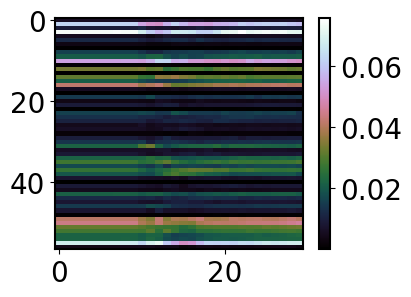

In [62]:
plt.figure(figsize=(4,3))
plt.imshow(torch.exp(log_pis.mean(0)).detach().numpy(), 
           aspect='auto', cmap='cubehelix')
plt.colorbar();

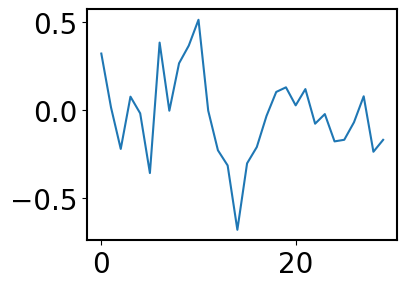

In [57]:
plt.figure(figsize=(4,3))
plt.plot(advi.beta.loc[1].detach().numpy());

In [447]:
# cont_y_enc_res = {
#     'bs': svi.bs,
#     'betas': svi.betas,
#     'means': svi.mu_locs,
#     'covs': svi.cov_covs
# }
# np.save(save_path + f'cont_y_enc_res_c{Nc}.npy', cont_y_enc_res)

#### MoG only

In [153]:
all_trials = np.concatenate(np.concatenate(data_loader.trials))[:,1:]
spike_times = data_loader.data[:,0]

spike_labels = []
spike_probs = []
spike_labels.extend(gmm.predict(all_trials))
spike_probs.extend(gmm.predict_proba(all_trials))
spike_labels = np.array(spike_labels)
spike_probs = np.array(spike_probs)

<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [154]:
enc_gmm = preprocess.compute_neural_activity(
    (spike_times, spike_labels, spike_probs),
    data_loader.stim_on_times,
    'clusterless', 
    n_time_bins=data_loader.n_t_bins
)
print(enc_gmm.shape)

(230, 57, 30)


In [183]:
train = data_loader.train_ids
test = data_loader.test_ids

In [156]:
x_train = enc_gmm.reshape(-1, enc_gmm.shape[1] * enc_gmm.shape[2])[train]
x_test = enc_gmm.reshape(-1, enc_gmm.shape[1] * enc_gmm.shape[2])[test]
y_train = data_loader.y[train]

ridge = Ridge(alpha=10000)
ridge.fit(x_train, y_train)
y_hat = ridge.predict(x_test)

In [157]:
print(f'R2 = {r2_score(data_loader.y[test], y_hat):.3f}')
print(f'MSE = {mean_squared_error(data_loader.y[test], y_hat):.3f}')
print(f'corr = {pearsonr(data_loader.y[test].flatten(), y_hat.flatten()).statistic:.3f}')

R2 = 0.016
MSE = 1.741
corr = 0.347


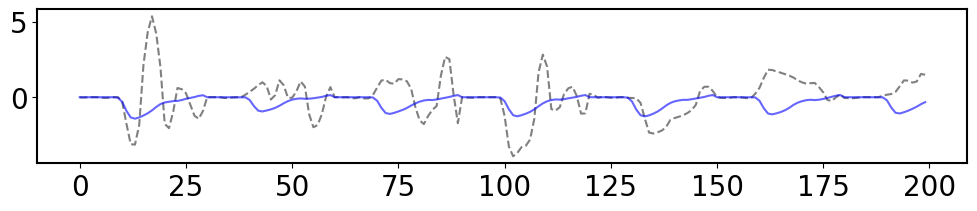

In [158]:
plt.figure(figsize=(12, 2))
plt.plot(data_loader.y[test].flatten()[:200], c='gray', linestyle='dashed', label='observed');
plt.plot(y_hat.flatten()[:200], c='blue', alpha=.6, label='predicted');

In [159]:
import time
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared, RationalQuadratic, RBF

long_term_trend_kernel = 50.0**2 * RBF(length_scale=50.0)
seasonal_kernel = (
    2.0**2
    * RBF(length_scale=100.0)
    * ExpSineSquared(length_scale=1.0, periodicity=1.0, periodicity_bounds="fixed")
)
# irregularities_kernel = 0.5**2 * RationalQuadratic(length_scale=1.0, alpha=1.0)
# noise_kernel = 0.1**2 * RBF(length_scale=0.1) + WhiteKernel(
#     noise_level=0.1**2, noise_level_bounds=(1e-5, 1e5)
# )
kernel = (
    long_term_trend_kernel #+ seasonal_kernel + noise_kernel #+ irregularities_kernel 
)
gaussian_process = GaussianProcessRegressor(kernel=kernel, alpha=1e-10)
start_time = time.time()
gaussian_process.fit(x_train, y_train)
print(
    f"Time for GaussianProcessRegressor fitting: {time.time() - start_time:.3f} seconds"
)
gp_pred = gaussian_process.predict(x_test)
print(f'R2 = {r2_score(data_loader.y[test], gp_pred):.3f}')
print(f'MSE = {mean_squared_error(data_loader.y[test], gp_pred):.3f}')
print(f'corr = {pearsonr(data_loader.y[test].flatten(), gp_pred.flatten()).statistic:.3f}')

Time for GaussianProcessRegressor fitting: 0.743 seconds
R2 = 0.102
MSE = 1.329
corr = 0.573


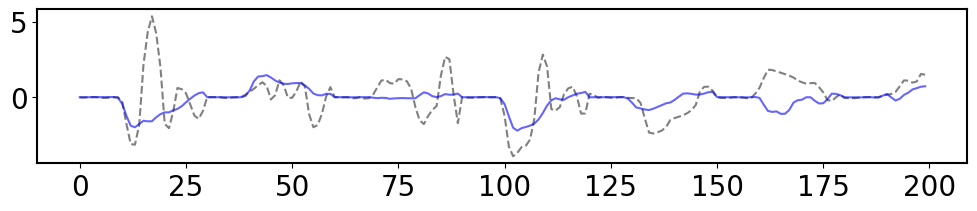

In [160]:
plt.figure(figsize=(12, 2))
plt.plot(data_loader.y[test].flatten()[:200], c='gray', linestyle='dashed', label='observed');
plt.plot(gp_pred.flatten()[:200], c='blue', alpha=.6, label='predicted');

In [161]:
windowed_enc_gmm, half_window_size, n_windows = decoder.sliding_window(
    enc_gmm, 
    data_loader.n_trials,
    window_size = 7
)
windowed_y = data_loader.y[:,half_window_size:n_windows].reshape(-1,1)

In [162]:
x_by_trial = windowed_enc_gmm.reshape((data_loader.n_trials, -1))
y_by_trial = windowed_y.reshape((data_loader.n_trials, -1))
x_train, x_test = x_by_trial[train], x_by_trial[test]
y_train, y_test = y_by_trial[train], y_by_trial[test]

x_train = x_train.reshape((-1, windowed_enc_gmm.shape[1]))
x_test = x_test.reshape((-1, windowed_enc_gmm.shape[1]))
y_train = y_train.flatten()
y_test = y_test.flatten()

ridge = Ridge(alpha=10000)
ridge.fit(x_train, y_train)
y_pred = ridge.predict(x_test)

In [163]:
print(f'R2 = {r2_score(y_test, y_pred):.3f}')
print(f'MSE = {mean_squared_error(y_test, y_pred):.3f}')
print(f'corr = {pearsonr(y_test, y_pred).statistic:.3f}')

R2 = 0.077
MSE = 2.141
corr = 0.346


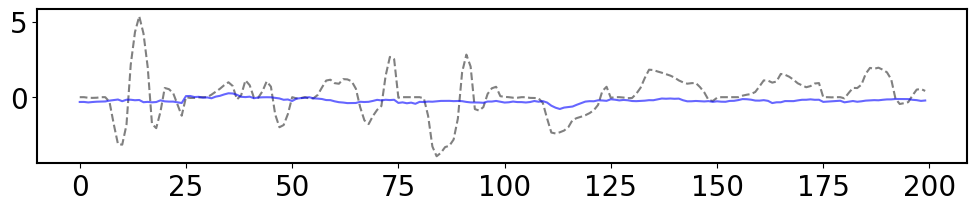

In [164]:
plt.figure(figsize=(12, 2))
plt.plot(y_test[:200], c='gray', linestyle='dashed', label='observed');
plt.plot(y_pred[:200], c='blue', alpha=.6, label='predicted');

#### encoding MoG

In [165]:
n_trials = stim_on_times.shape[0]
unsorted = np.vstack([unsorted_trials[i] for i in np.arange(n_trials)]) 
spike_times = unsorted[:,0]
spike_channels = unsorted[:,1]
spike_features = unsorted[:,2:]

thresholded_neural_data = preprocess.compute_neural_activity(
    (spike_times, spike_channels),
    stim_on_times,
    'thresholded', 
    n_time_bins=30,
    # regional=True
    regional=False
)
print(f'thresholded neural data shape: {thresholded_neural_data.shape}')

thresholded neural data shape: (230, 254, 30)


In [166]:
x_train = thresholded_neural_data.reshape(-1, thresholded_neural_data.shape[1] * thresholded_neural_data.shape[2])[train]
x_test = thresholded_neural_data.reshape(-1, thresholded_neural_data.shape[1] * thresholded_neural_data.shape[2])[test]
y_train = data_loader.y[train]

ridge = Ridge(alpha=10000)
ridge.fit(x_train, y_train)
y_hat = ridge.predict(x_test)

In [167]:
print(f'R2 = {r2_score(data_loader.y[test], y_hat):.3f}')
print(f'MSE = {mean_squared_error(data_loader.y[test], y_hat):.3f}')
print(f'corr = {pearsonr(data_loader.y[test].flatten(), y_hat.flatten()).statistic:.3f}')

R2 = 0.056
MSE = 1.609
corr = 0.442


In [168]:
import time
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared, RationalQuadratic, RBF

long_term_trend_kernel = 50.0**2 * RBF(length_scale=50.0)
seasonal_kernel = (
    2.0**2
    * RBF(length_scale=100.0)
    * ExpSineSquared(length_scale=1.0, periodicity=1.0, periodicity_bounds="fixed")
)
# irregularities_kernel = 0.5**2 * RationalQuadratic(length_scale=1.0, alpha=1.0)
# noise_kernel = 0.1**2 * RBF(length_scale=0.1) + WhiteKernel(
#     noise_level=0.1**2, noise_level_bounds=(1e-5, 1e5)
# )
kernel = (
    long_term_trend_kernel #+ seasonal_kernel #+ irregularities_kernel + noise_kernel
)
gaussian_process = GaussianProcessRegressor(kernel=kernel, alpha=1e-2)
start_time = time.time()
gaussian_process.fit(x_train, y_train)
print(
    f"Time for GaussianProcessRegressor fitting: {time.time() - start_time:.3f} seconds"
)
gp_pred = gaussian_process.predict(x_test)
print(f'R2 = {r2_score(data_loader.y[test], gp_pred):.3f}')
print(f'MSE = {mean_squared_error(data_loader.y[test], gp_pred):.3f}')
print(f'corr = {pearsonr(data_loader.y[test].flatten(), gp_pred.flatten()).statistic:.3f}')

Time for GaussianProcessRegressor fitting: 2.011 seconds
R2 = 0.138
MSE = 1.248
corr = 0.607


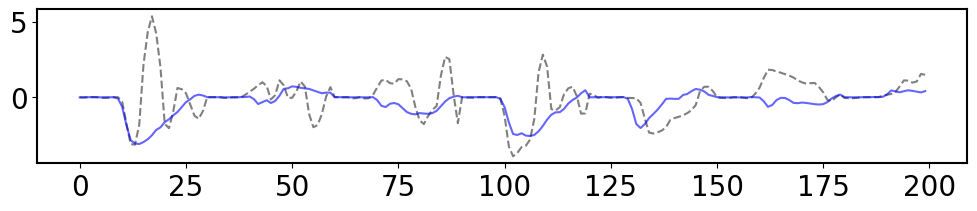

In [169]:
plt.figure(figsize=(12, 2))
plt.plot(data_loader.y[test].flatten()[:200], c='gray', linestyle='dashed', label='observed');
plt.plot(gp_pred.flatten()[:200], c='blue', alpha=.6, label='predicted');

In [170]:
log_lambdas_hat = np.zeros((data_loader.n_trials, Nc, Nt))
for k in range(len(train)):
    for t in range(Nt):
        log_lambdas_hat[k,:,t] = advi.b.loc.detach().numpy() + advi.beta.loc[:,t].detach().numpy() * y_train[k][t]

for k in range(len(test)):
    for t in range(Nt):
        log_lambdas_hat[k,:,t] = advi.b.loc.detach().numpy() + advi.beta.loc[:,t].detach().numpy() * y_hat[k][t]

log_pis_hat = log_lambdas_hat - logsumexp(log_lambdas_hat, 1)[:,None,:]

In [171]:
enc_pis = np.exp(log_pis_hat)
enc_means = advi.means.detach().numpy()
enc_covs = advi.covs.detach().numpy()

In [172]:
enc_all = np.zeros((data_loader.n_trials, Nc, Nt))

for k in range(enc_all.shape[0]):
    for t in range(Nt):
        enc_gmm =  GaussianMixture(n_components=Nc, covariance_type='full')
        enc_gmm.precisions_cholesky_ = np.linalg.cholesky(np.linalg.inv(enc_covs))
        enc_gmm.weights_ = enc_pis[k,:,t]
        # enc_gmm.weights_ = enc_pis[:,:,t].mean(0)
        enc_gmm.means_ = enc_means
        enc_gmm.covariances_ = enc_covs
        if len(data_loader.trials[k][t]) > 0:
            enc_all[k,:,t] = enc_gmm.predict_proba(data_loader.trials[k][t][:,1:]).sum(0)

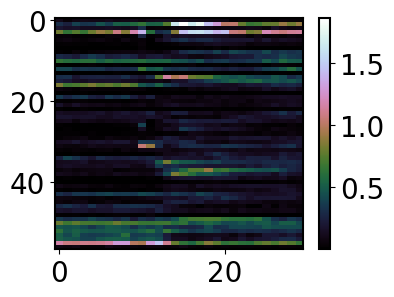

In [173]:
plt.figure(figsize=(4,3))
plt.imshow(enc_all.mean(0), aspect='auto', cmap='cubehelix')
plt.colorbar();

In [184]:
x_train = enc_all.reshape(-1, enc_all.shape[1] * enc_all.shape[2])[train]
x_test = enc_all.reshape(-1, enc_all.shape[1] * enc_all.shape[2])[test]
y_train = data_loader.y[train]

ridge = Ridge(alpha=10000)
ridge.fit(x_train, y_train)
y_hat = ridge.predict(x_test)

In [185]:
print(f'R2 = {r2_score(data_loader.y[test], y_hat):.3f}')
print(f'MSE = {mean_squared_error(data_loader.y[test], y_hat):.3f}')
print(f'corr = {pearsonr(data_loader.y[test].flatten(), y_hat.flatten()).statistic:.3f}')

R2 = 0.054
MSE = 1.609
corr = 0.442


In [186]:
import time
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared, RationalQuadratic, RBF

long_term_trend_kernel = 50.0**2 * RBF(length_scale=50.0)
seasonal_kernel = (
    2.0**2
    * RBF(length_scale=100.0)
    * ExpSineSquared(length_scale=1.0, periodicity=1.0, periodicity_bounds="fixed")
)
# irregularities_kernel = 0.5**2 * RationalQuadratic(length_scale=1.0, alpha=1.0)
# noise_kernel = 0.1**2 * RBF(length_scale=0.1) + WhiteKernel(
#     noise_level=0.1**2, noise_level_bounds=(1e-5, 1e5)
# )
kernel = (
    long_term_trend_kernel #+ seasonal_kernel + noise_kernel #+ irregularities_kernel 
)
gaussian_process = GaussianProcessRegressor(kernel=kernel, alpha=1e-10)
start_time = time.time()
gaussian_process.fit(x_train, y_train)
print(
    f"Time for GaussianProcessRegressor fitting: {time.time() - start_time:.3f} seconds"
)
gp_pred = gaussian_process.predict(x_test)
print(f'R2 = {r2_score(data_loader.y[test], gp_pred):.3f}')
print(f'MSE = {mean_squared_error(data_loader.y[test], gp_pred):.3f}')
print(f'corr = {pearsonr(data_loader.y[test].flatten(), gp_pred.flatten()).statistic:.3f}')

Time for GaussianProcessRegressor fitting: 0.813 seconds
R2 = 0.154
MSE = 1.181
corr = 0.634


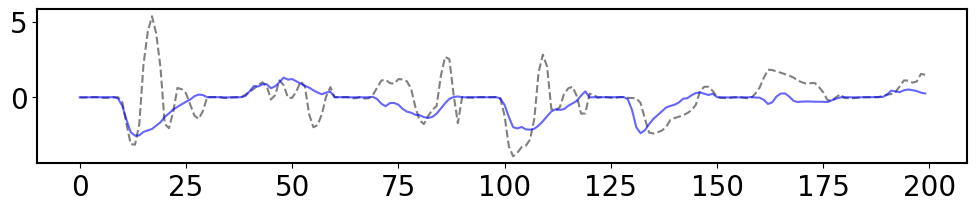

In [187]:
plt.figure(figsize=(12, 2))
plt.plot(data_loader.y[test].flatten()[:200], c='gray', linestyle='dashed', label='observed');
plt.plot(gp_pred.flatten()[:200], c='blue', alpha=.6, label='predicted');

In [188]:
windowed_enc_all, half_window_size, n_windows = decoder.sliding_window(
    enc_all, 
    data_loader.n_trials,
    window_size = 7
)
windowed_y = data_loader.y[:,half_window_size:n_windows].reshape(-1,1)

In [189]:
x_by_trial = windowed_enc_all.reshape((data_loader.n_trials, -1))
y_by_trial = windowed_y.reshape((data_loader.n_trials, -1))
x_train, x_test = x_by_trial[train], x_by_trial[test]
y_train, y_test = y_by_trial[train], y_by_trial[test]

x_train = x_train.reshape((-1, windowed_enc_all.shape[1]))
x_test = x_test.reshape((-1, windowed_enc_all.shape[1]))
y_train = y_train.flatten()
y_test = y_test.flatten()

In [190]:
ridge = Ridge(alpha=10000)
ridge.fit(x_train, y_train)
y_pred = ridge.predict(x_test)

In [191]:
print(f'R2 = {r2_score(y_test, y_pred):.3f}')
print(f'MSE = {mean_squared_error(y_test, y_pred):.3f}')
print(f'corr = {pearsonr(y_test, y_pred).statistic:.3f}')

R2 = 0.190
MSE = 1.879
corr = 0.516


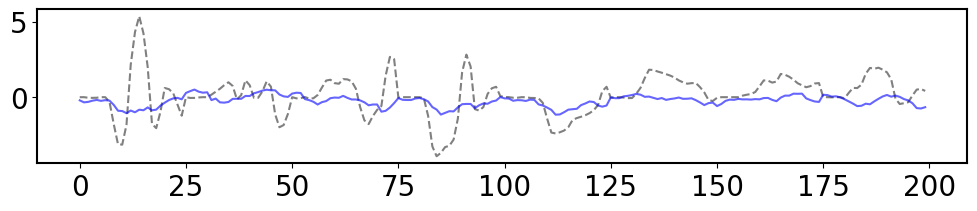

In [192]:
plt.figure(figsize=(12, 2))
plt.plot(y_test[:200], c='gray', linestyle='dashed', label='observed');
plt.plot(y_pred[:200], c='blue', alpha=.6, label='predicted');

#### thresholded

In [193]:
windowed_thresh, half_window_size, n_windows = decoder.sliding_window(
    thresholded_neural_data, 
    data_loader.n_trials,
    window_size = 7
)
windowed_y = data_loader.y[:,half_window_size:n_windows].reshape(-1,1)

In [194]:
x_by_trial = windowed_thresh.reshape((data_loader.n_trials, -1))
y_by_trial = windowed_y.reshape((data_loader.n_trials, -1))
x_train, x_test = x_by_trial[train], x_by_trial[test]
y_train, y_test = y_by_trial[train], y_by_trial[test]

x_train = x_train.reshape((-1, windowed_thresh.shape[1]))
x_test = x_test.reshape((-1, windowed_thresh.shape[1]))
y_train = y_train.flatten()
y_test = y_test.flatten()

In [195]:
ridge = Ridge(alpha=10000)
ridge.fit(x_train, y_train)
y_pred = ridge.predict(x_test)

In [196]:
print(f'R2 = {r2_score(y_test, y_pred):.3f}')
print(f'MSE = {mean_squared_error(y_test, y_pred):.3f}')
print(f'corr = {pearsonr(y_test, y_pred).statistic:.3f}')

R2 = 0.171
MSE = 1.923
corr = 0.476


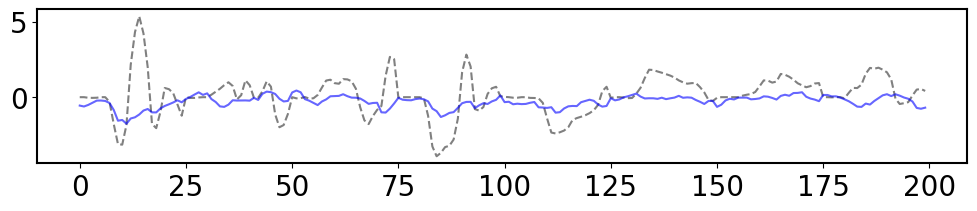

In [197]:
plt.figure(figsize=(12, 2))
plt.plot(y_test[:200], c='gray', linestyle='dashed', label='observed');
plt.plot(y_pred[:200], c='blue', alpha=.6, label='predicted');

#### KS & good IBL units

In [198]:
n_trials = stim_on_times.shape[0]
sorted = np.vstack([sorted_trials[i] for i in np.arange(n_trials)]) 
spike_times = sorted[:,0]
spike_clusters = sorted[:,1]

sorted_neural_data = preprocess.compute_neural_activity(
    (spike_times, spike_clusters),
    stim_on_times,
    'sorted', 
    n_time_bins=30,
    regional=True
)
print(f'sorted neural data shape: {sorted_neural_data.shape}')

good_sorted = np.vstack([good_sorted_trials[i] for i in np.arange(n_trials)]) 
spike_times = good_sorted[:,0]
spike_clusters = good_sorted[:,1]

good_sorted_neural_data = preprocess.compute_neural_activity(
    (spike_times, spike_clusters),
    stim_on_times,
    'sorted', 
    n_time_bins=30,
    regional=True
)
print(f'good sorted neural data shape: {good_sorted_neural_data.shape}')

sorted neural data shape: (230, 86, 30)
good sorted neural data shape: (230, 18, 30)


In [199]:
x_train = sorted_neural_data.reshape(-1, sorted_neural_data.shape[1] * sorted_neural_data.shape[2])[train]
x_test = sorted_neural_data.reshape(-1, sorted_neural_data.shape[1] * sorted_neural_data.shape[2])[test]
y_train = data_loader.y[train]

ridge = Ridge(alpha=10000)
ridge.fit(x_train, y_train)
y_hat = ridge.predict(x_test)

In [200]:
print(f'R2 = {r2_score(data_loader.y[test], y_hat):.3f}')
print(f'MSE = {mean_squared_error(data_loader.y[test], y_hat):.3f}')
print(f'corr = {pearsonr(data_loader.y[test].flatten(), y_hat.flatten()).statistic:.3f}')

R2 = 0.055
MSE = 1.602
corr = 0.448


In [201]:
import time
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared, RationalQuadratic, RBF

long_term_trend_kernel = 50.0**2 * RBF(length_scale=50.0)
seasonal_kernel = (
    2.0**2
    * RBF(length_scale=100.0)
    * ExpSineSquared(length_scale=1.0, periodicity=1.0, periodicity_bounds="fixed")
)
# irregularities_kernel = 0.5**2 * RationalQuadratic(length_scale=1.0, alpha=1.0)
noise_kernel = 0.1**2 * RBF(length_scale=0.1) + WhiteKernel(
    noise_level=0.1**2, noise_level_bounds=(1e-5, 1e5)
)
kernel = (
    long_term_trend_kernel #+ seasonal_kernel + noise_kernel #+ irregularities_kernel
)
gaussian_process = GaussianProcessRegressor(kernel=kernel, alpha=1e-2)
start_time = time.time()
gaussian_process.fit(x_train, y_train)
print(
    f"Time for GaussianProcessRegressor fitting: {time.time() - start_time:.3f} seconds"
)
gp_pred = gaussian_process.predict(x_test)
print(f'R2 = {r2_score(data_loader.y[test], gp_pred):.3f}')
print(f'MSE = {mean_squared_error(data_loader.y[test], gp_pred):.3f}')
print(f'corr = {pearsonr(data_loader.y[test].flatten(), gp_pred.flatten()).statistic:.3f}')

Time for GaussianProcessRegressor fitting: 1.067 seconds
R2 = 0.159
MSE = 1.175
corr = 0.636


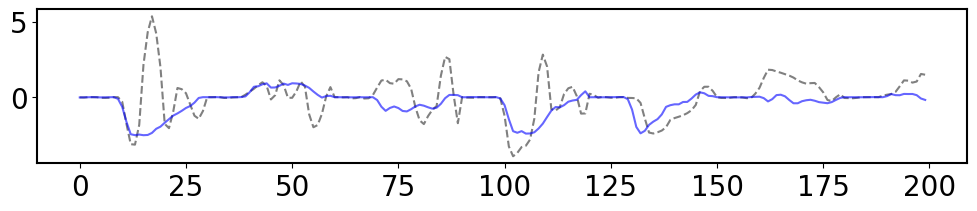

In [202]:
plt.figure(figsize=(12, 2))
plt.plot(data_loader.y[test].flatten()[:200], c='gray', linestyle='dashed', label='observed');
plt.plot(gp_pred.flatten()[:200], c='blue', alpha=.6, label='predicted');

In [203]:
windowed_sorted, half_window_size, n_windows = decoder.sliding_window(
    sorted_neural_data, 
    data_loader.n_trials,
    window_size = 7
)

windowed_good_units, half_window_size, n_windows = decoder.sliding_window(
    good_sorted_neural_data, 
    data_loader.n_trials,
    window_size = 7
)
windowed_y = data_loader.y[:,half_window_size:n_windows].reshape(-1,1)

In [204]:
x_by_trial = windowed_sorted.reshape((data_loader.n_trials, -1))
y_by_trial = windowed_y.reshape((data_loader.n_trials, -1))
x_train, x_test = x_by_trial[train], x_by_trial[test]
y_train, y_test = y_by_trial[train], y_by_trial[test]

x_train = x_train.reshape((-1, windowed_sorted.shape[1]))
x_test = x_test.reshape((-1, windowed_sorted.shape[1]))
y_train = y_train.flatten()
y_test = y_test.flatten()

ridge = Ridge(alpha=10000)
ridge.fit(x_train, y_train)
y_pred = ridge.predict(x_test)

In [206]:
print(f'R2 = {r2_score(y_test, y_pred):.3f}')
print(f'MSE = {mean_squared_error(y_test, y_pred):.3f}')
print(f'corr = {pearsonr(y_test, y_pred).statistic:.3f}')

R2 = 0.216
MSE = 1.818
corr = 0.549


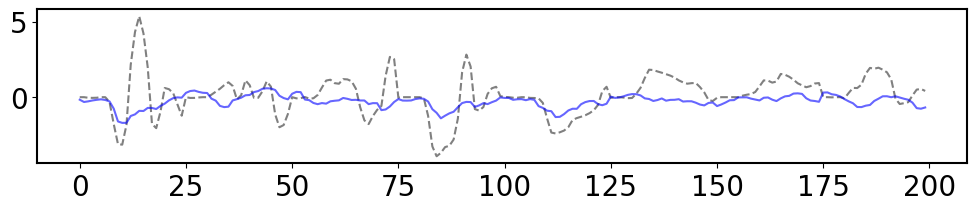

In [207]:
plt.figure(figsize=(12, 2))
plt.plot(y_test[:200], c='gray', linestyle='dashed', label='observed');
plt.plot(y_pred[:200], c='blue', alpha=.6, label='predicted');

In [208]:
x_train = good_sorted_neural_data.reshape(-1, good_sorted_neural_data.shape[1] * good_sorted_neural_data.shape[2])[train]
x_test = good_sorted_neural_data.reshape(-1, good_sorted_neural_data.shape[1] * good_sorted_neural_data.shape[2])[test]
y_train = data_loader.y[train]

ridge = Ridge(alpha=10000)
ridge.fit(x_train, y_train)
y_hat = ridge.predict(x_test)

In [209]:
print(f'R2 = {r2_score(data_loader.y[test], y_hat):.3f}')
print(f'MSE = {mean_squared_error(data_loader.y[test], y_hat):.3f}')
print(f'corr = {pearsonr(data_loader.y[test].flatten(), y_hat.flatten()).statistic:.3f}')

R2 = 0.001
MSE = 1.792
corr = 0.309


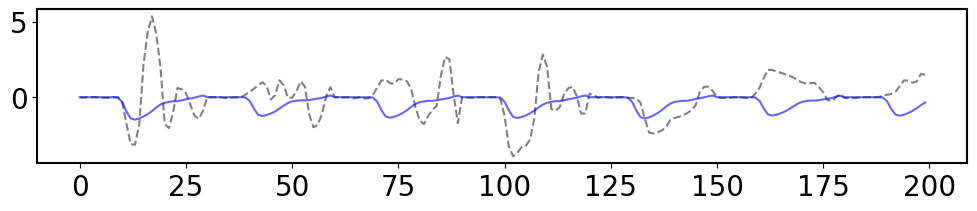

In [210]:
plt.figure(figsize=(12, 2))
plt.plot(data_loader.y[test].flatten()[:200], c='gray', linestyle='dashed', label='observed');
plt.plot(y_hat.flatten()[:200], c='blue', alpha=.6, label='predicted');

In [211]:
import time
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared, RationalQuadratic, RBF

long_term_trend_kernel = 50.0**2 * RBF(length_scale=50.0)
seasonal_kernel = (
    2.0**2
    * RBF(length_scale=100.0)
    * ExpSineSquared(length_scale=1.0, periodicity=1.0, periodicity_bounds="fixed")
)
# irregularities_kernel = 0.5**2 * RationalQuadratic(length_scale=1.0, alpha=1.0)
noise_kernel = 0.1**2 * RBF(length_scale=0.1) + WhiteKernel(
    noise_level=0.1**2, noise_level_bounds=(1e-5, 1e5)
)
kernel = (
    long_term_trend_kernel #+ seasonal_kernel + noise_kernel #+ irregularities_kernel
)
gaussian_process = GaussianProcessRegressor(kernel=kernel, alpha=1e-2)
start_time = time.time()
gaussian_process.fit(x_train, y_train)
print(
    f"Time for GaussianProcessRegressor fitting: {time.time() - start_time:.3f} seconds"
)
gp_pred = gaussian_process.predict(x_test)
print(f'R2 = {r2_score(data_loader.y[test], gp_pred):.3f}')
print(f'MSE = {mean_squared_error(data_loader.y[test], gp_pred):.3f}')
print(f'corr = {pearsonr(data_loader.y[test].flatten(), gp_pred.flatten()).statistic:.3f}')

Time for GaussianProcessRegressor fitting: 0.529 seconds
R2 = 0.008
MSE = 1.685
corr = 0.413


In [212]:
x_by_trial = windowed_good_units.reshape((data_loader.n_trials, -1))
y_by_trial = windowed_y.reshape((data_loader.n_trials, -1))
x_train, x_test = x_by_trial[train], x_by_trial[test]
y_train, y_test = y_by_trial[train], y_by_trial[test]

x_train = x_train.reshape((-1, windowed_good_units.shape[1]))
x_test = x_test.reshape((-1, windowed_good_units.shape[1]))
y_train = y_train.flatten()
y_test = y_test.flatten()

ridge = Ridge(alpha=2000)
ridge.fit(x_train, y_train)
y_pred = ridge.predict(x_test)

In [213]:
print(f'R2 = {r2_score(y_test, y_pred):.3f}')
print(f'MSE = {mean_squared_error(y_test, y_pred):.3f}')
print(f'corr = {pearsonr(y_test, y_pred).statistic:.3f}')

R2 = 0.058
MSE = 2.186
corr = 0.255


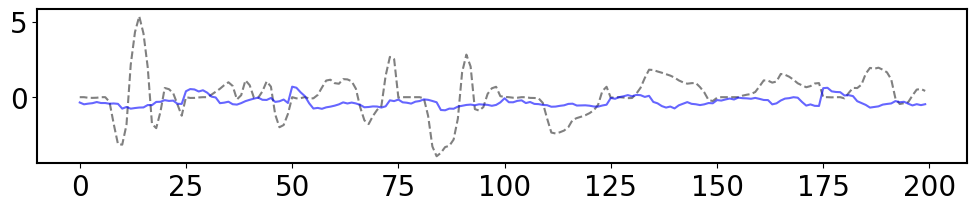

In [214]:
plt.figure(figsize=(12, 2))
plt.plot(y_test[:200], c='gray', linestyle='dashed', label='observed');
plt.plot(y_pred[:200], c='blue', alpha=.6, label='predicted');